In [1]:
import pandas as pd
from src.ticket_messages import TicketMessage

In [2]:
df = pd.read_parquet("data/classification_dataset")

In [3]:
df.tail()

account_id ticket_id             raw_body channel  unix_timestamp   
56167      47355  97704266 -7329393197999221857   email    1.683747e+09  \
56168      47355  97104492  -712526401448959206   email    1.683821e+09   
56169      47355  98114244 -6396575246795551664   email    1.683823e+09   
56170      47355  98375668  8956876459394868202   email    1.684164e+09   
56171      47355  98834917  3230166170796936168   email    1.684271e+09   

                   contact_reason       processed_body   
56167  "Pre-sale::Place an order"  7769862566240229096  \
56168     "No Action Req::Others"  8225526187121867386   
56169     "No Action Req::Others"                    0   
56170     "Tech Supp::Tech_Query"  4884952985295307657   
56171        "Shipping::Tracking"  1023372247625818182   

                               email_sentence_embeddings  
56167  {"7076610397638084948": [0.04829759523272514, ...  
56168  {"-4707052099692602634": [0.04418250918388367,...  
56169                                               None  
56170  {"-6790423425691970518": [-0.10473562777042389...  
56171  {"1824102601729972162": [-0.02185063622891903,...

In [4]:
ticket_message_list = TicketMessage.from_dataframe(dataframe=df)

In [5]:
i = 13524

print(f"Account id = {ticket_message_list[i].account_id}")
print(f"Ticket id = {ticket_message_list[i].ticket_id}")
print(f"Contact Reason = ", ticket_message_list[i].contact_reason)
if ticket_message_list[i].email_sentence_embeddings:
    print(f"Number of sentences in email = ", len(ticket_message_list[i].email_sentence_embeddings))
else:
    print(f"Number of sentences in email = ", 0)

Account id = 4453
Ticket id = 375526423
Contact Reason =  "Post-purchase::Other::Other"
Number of sentences in email =  3


# Journey (ML project lifecycle)

The journey consists of the following essential steps:

- **Scope**: Understand the project scope and business needs.
- **Data**: Understand the given data by conducting exploration data analysis (EDA)
  - Explore the dependent variable (target).
  - Explore the independent variables (features).
- **Modeling**: Build a proof of concept solution (PoC)
  - Select and train model.
  - Perform error analysis.
- **Deployment**: Deploy the PoC solution
  - Deploy model or models into production using FastAPI.
  - Monitor & maintain production system.

## Scope: Project Overview

- At Gorgias, we handle merchant customer tickets and provide a software platform that allows the tagging of tickets with the customer contact reason. 

- Each client has a **unique set of contact reasons**, making building a flexible and adaptable classification system essential.

- Automating the classification of these tickets based on merchant-specific contact reasons can significantly improve efficiency and enhance customer support.

- This project aims to develop a machine-learning solution to automate the classification of merchant customer tickets based on their contact reasons. 

- Please bear in mind that the final solution would handle about 250K tickets on a daily basis with an expected response time of around 200ms.

## Data: Exploration data analysis (EDA)

In [6]:
# import necessary libs

import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from datetime import datetime
from sklearn.manifold import TSNE
from wordcloud import WordCloud, STOPWORDS

%config InlineBackend.figure_format='retina'
%matplotlib inline

## Data info
- **account_id**: str, Unique merchant ID.
- **ticket_id**: str, Unique ticket ID.
- **raw_body**: str, Hashed representation of the received message.
- **channel**: str, Channel from which the message was received (in this case, emails).
- **unix_timestamp**: float, Timestamp indicating when the ticket was created.
- **contact_reason**: str, the contact reason label associated with the message.
- **processed_body**: str, Hashed representation of the message after processing.
- **email_sentence_embeddings**: str, JSON string format containing a dictionary of hashed extracted sentences from the email and their embeddings.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56172 entries, 0 to 56171
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   account_id                 56172 non-null  object 
 1   ticket_id                  56172 non-null  object 
 2   raw_body                   56172 non-null  int64  
 3   channel                    56172 non-null  object 
 4   unix_timestamp             56172 non-null  float64
 5   contact_reason             56172 non-null  object 
 6   processed_body             56172 non-null  int64  
 7   email_sentence_embeddings  50719 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 3.4+ MB


## Target variable info

In [8]:
df.contact_reason.unique().shape[0]

1776

In [9]:
client_agg = df.groupby("account_id")
client_agg.size().shape[0]

67

There are **1776** unique labels associated with the email messages distributed across **67** unique clients that are presented in the data

In [10]:

client_agg_cnt = client_agg.contact_reason.apply(lambda x: x.unique().shape[0]) \
                           .to_frame("#_contact_reasons_per_client") \
                           .sort_values("#_contact_reasons_per_client")

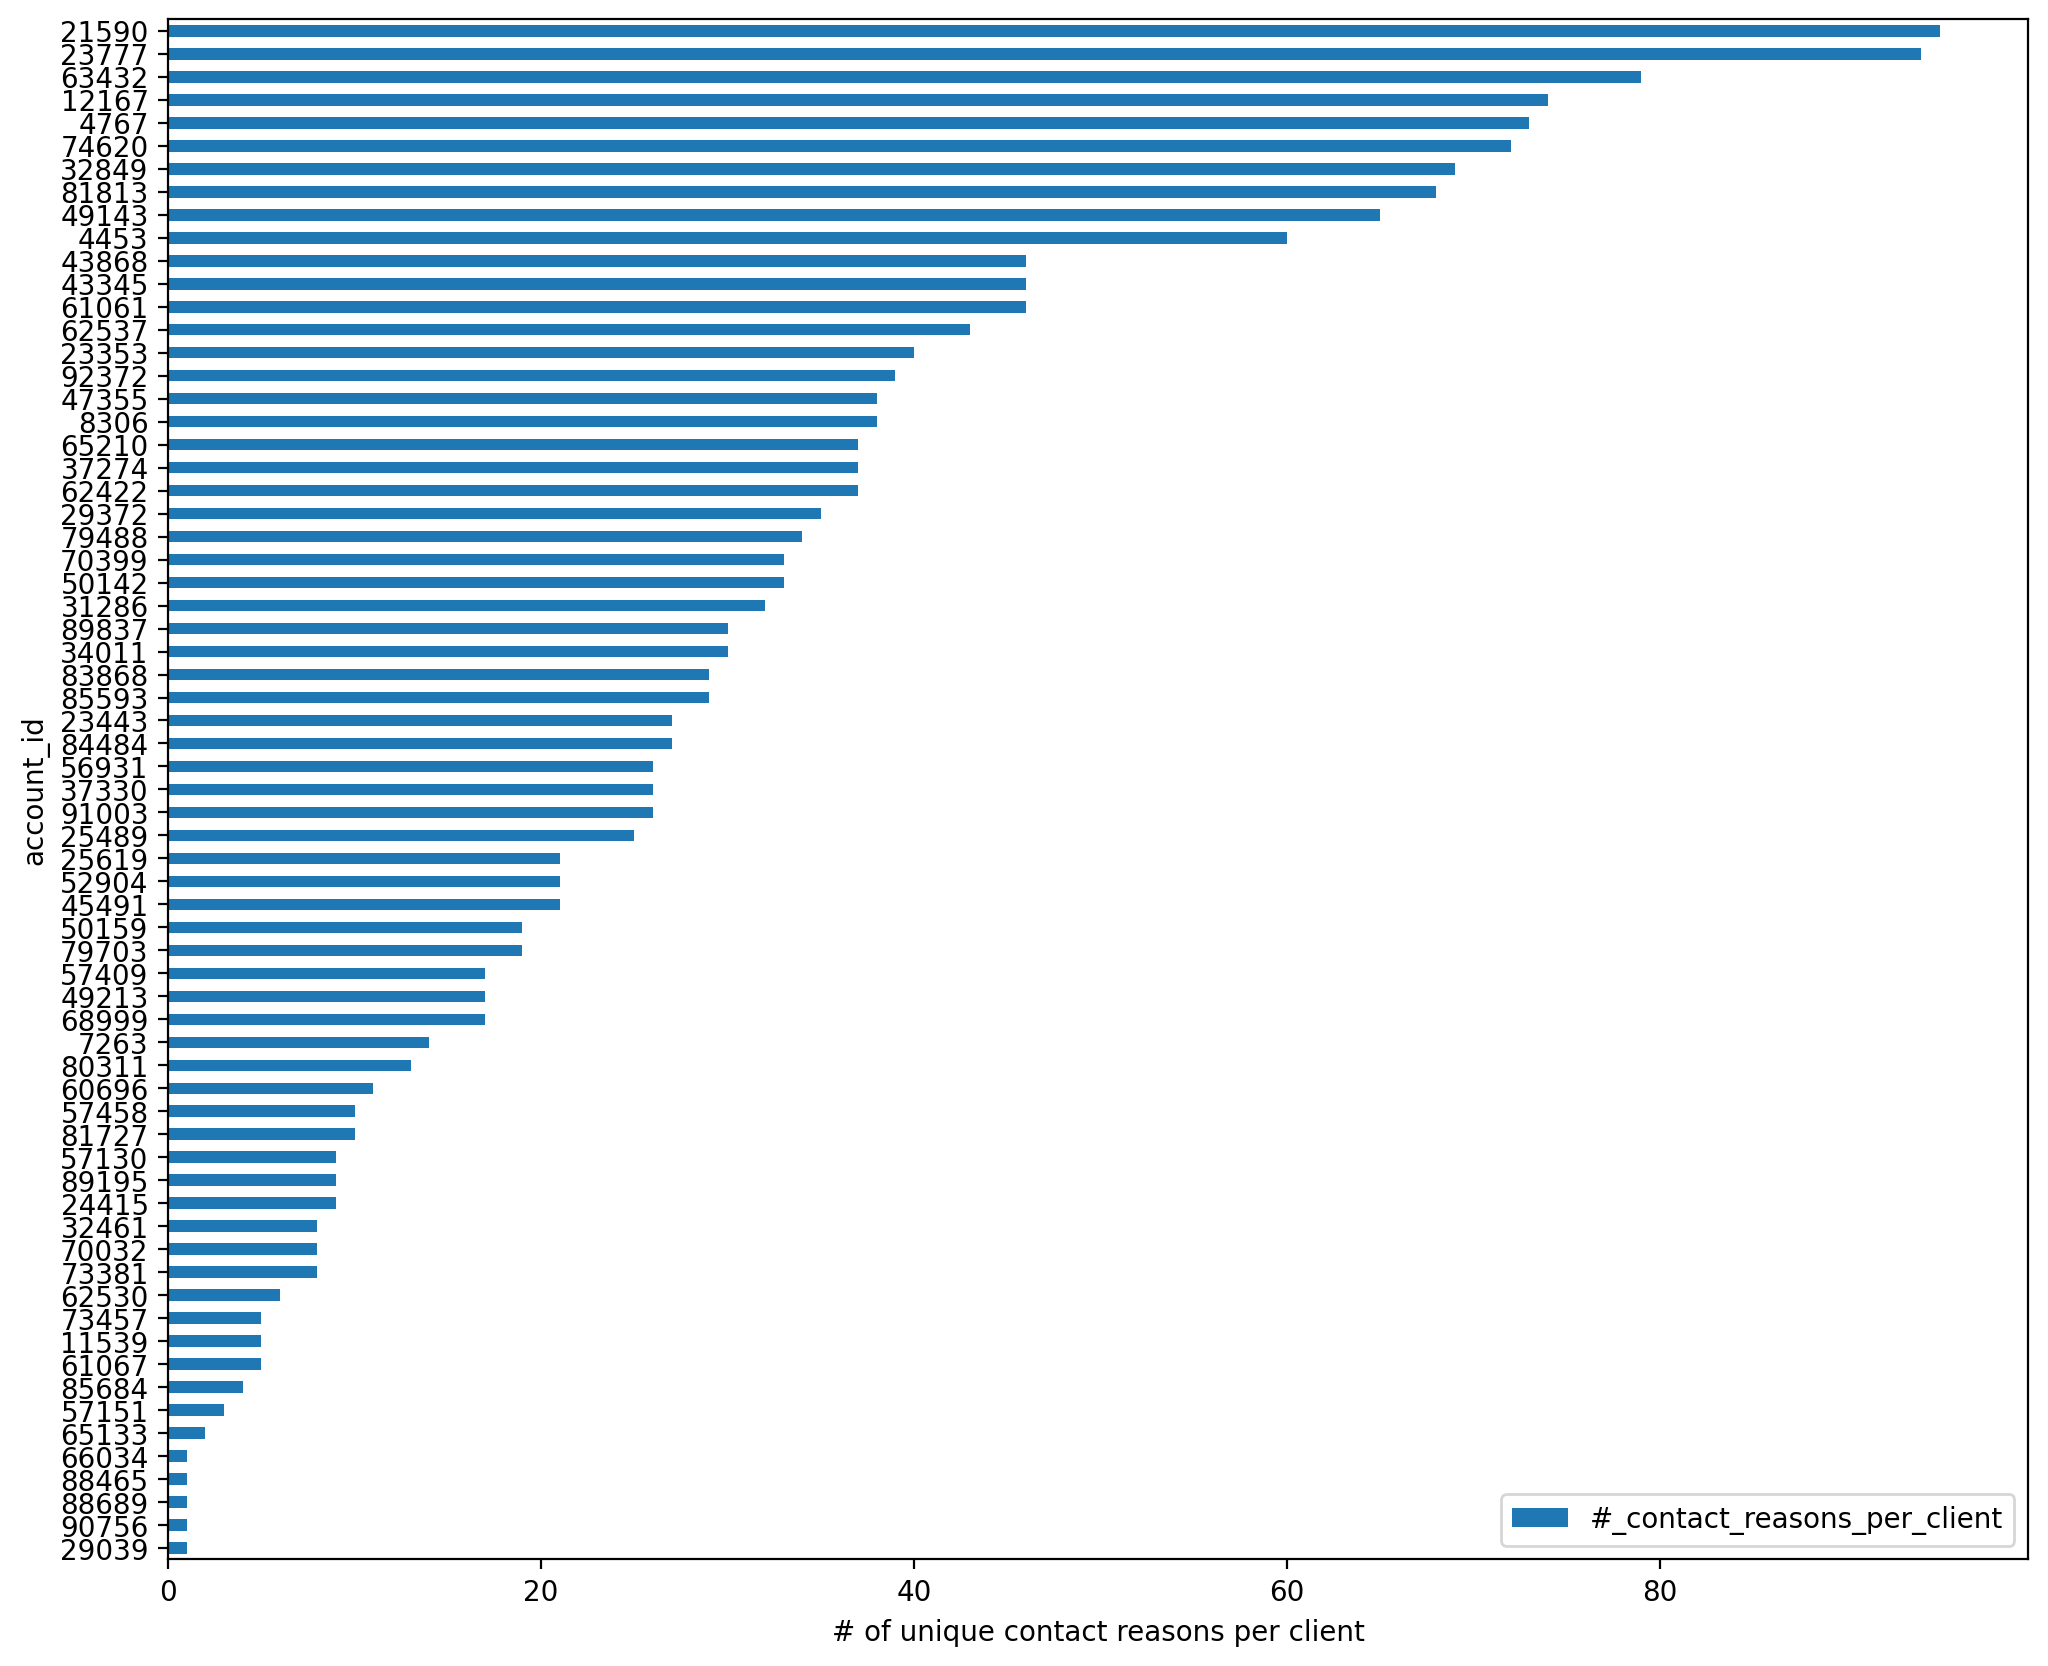

In [11]:
client_agg_cnt.plot(kind='barh', xlabel="# of unique contact reasons per client", figsize=(12, 10))
plt.show()

The figure shows the number of unique contact reasons per client. The distribution is quite skewed so we have clients with very few number of unique labels.

In [12]:
client_agg_cnt.head(10)

#_contact_reasons_per_client
account_id                              
29039                                  1
90756                                  1
88689                                  1
88465                                  1
66034                                  1
65133                                  2
57151                                  3
85684                                  4
61067                                  5
11539                                  5

The following clients *29039*, *90756*, *88689*, *88465*, *66034* have only one contact reason. This needs to be considered in a PoC.

In [13]:
client_agg_set = client_agg.contact_reason.apply(lambda x: set(x))

In [14]:
top_client_ids = client_agg_cnt.tail(10).index.tolist()

In [15]:
all_client_ids = client_agg_cnt.index.tolist()
common_labels = set()

for account_id1 in all_client_ids:
    for account_id2 in all_client_ids:
        if account_id1 != account_id2:
            overlap_set = client_agg_set[account_id1].intersection(client_agg_set[account_id2])
            n_overlaps = len(overlap_set)
            if n_overlaps > 0:
                common_labels = common_labels.union(overlap_set)
                # print(f"There are {n_overlaps} overlaps in labels for the clients {account_id1} and {account_id2}")
                # print(overlap_set)
                # print("-----")

len(common_labels)

67

In [16]:
list(common_labels)[:10]

['"Warranty"',
 '"Other"',
 '"Order::Cancel"',
 '"Shipping Issue"',
 '"Order::Missing Item"',
 '"Order Query"',
 '"Damaged Order"',
 '"Spam"',
 '"Exchange/Return::Change of mind"',
 '"Shipping::WISMO"']

From the description we have that each client has a **unique set of contact reasons**, however some of the clients share **67** out of **1776** contact reasons such as "Other", "Cancel order" and "Social Media". Coincidence? :)

In [17]:
client_agg_list = client_agg.contact_reason.apply(lambda x: x.tolist())

In [18]:
wc = WordCloud(stopwords=STOPWORDS, max_words=100, width=800, height=400)

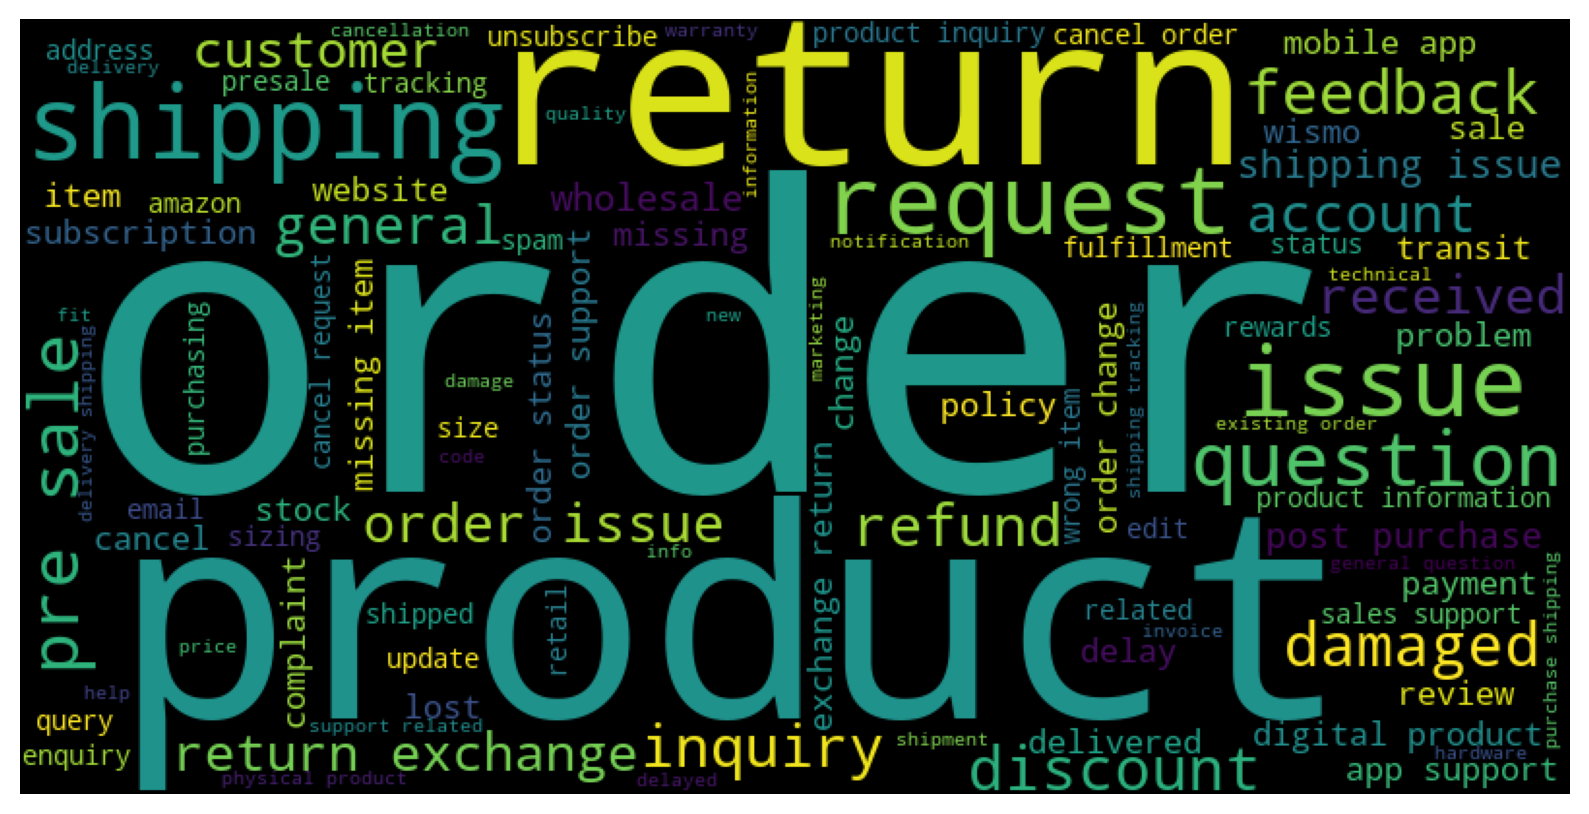

In [19]:
plt.figure(figsize=(10, 6))
contact_reasons = np.concatenate([l for l in client_agg_list.values])
contact_reasons = np.unique(contact_reasons).tolist()
wc.generate(' '.join([w.replace('"', '').lower() for w in contact_reasons]))
plt.axis("off")
plt.imshow(wc)
plt.show()

WordCloud helps better understand the general overview of the contact reason labels per client. As I might observe from the figure that the majority of contact reasons are related to **shipping**, **order** and **return** of a **product**.

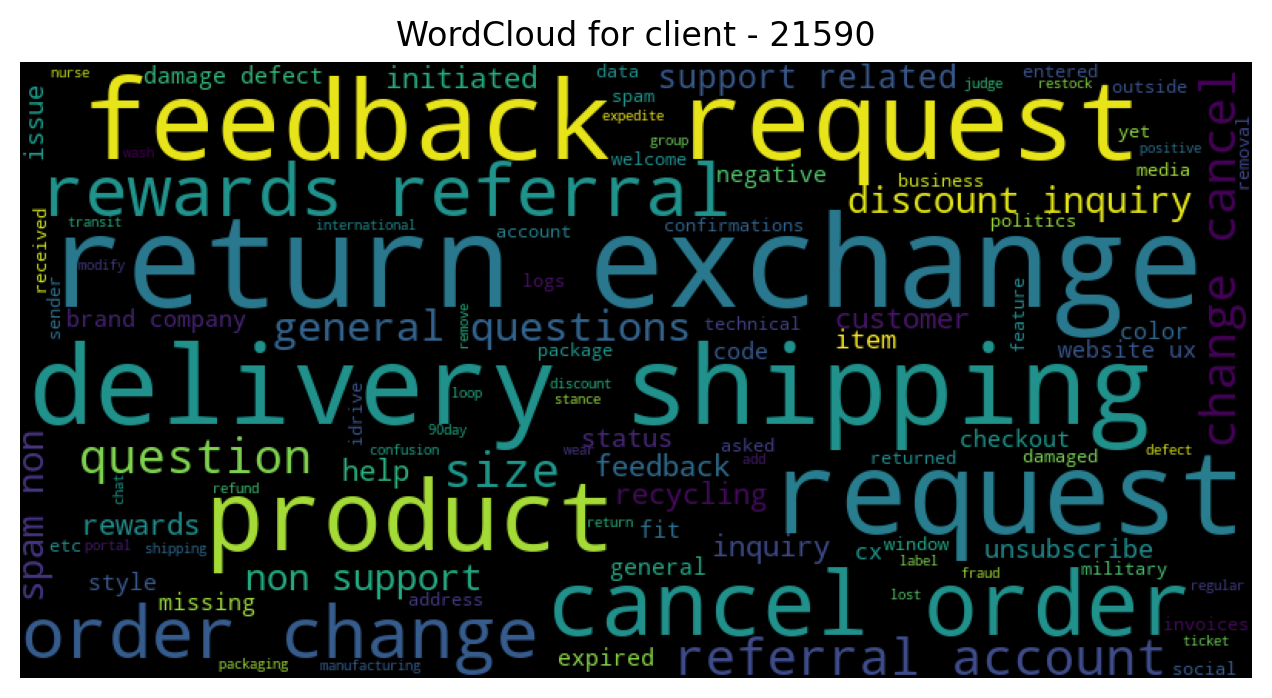

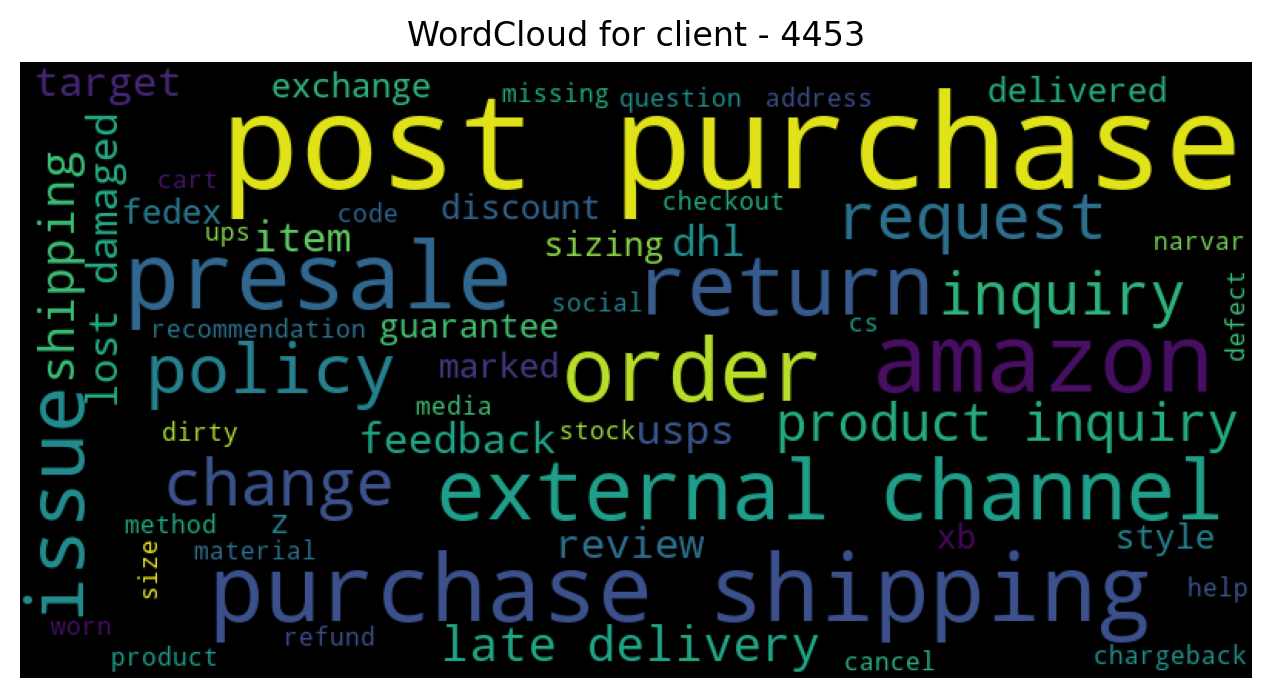

In [20]:
plt.figure(figsize=(8, 4))
contact_reasons = np.concatenate([l for l in client_agg_list[client_agg_list.index == top_client_ids[-1]].values])
contact_reasons = np.unique(contact_reasons).tolist()
wc.generate(' '.join([w.replace('"', '').lower() for w in contact_reasons]))
plt.axis("off")
plt.title(f"WordCloud for client - {top_client_ids[-1]}")
plt.imshow(wc)
plt.show()

plt.figure(figsize=(8, 4))
contact_reasons = np.concatenate([l for l in client_agg_list[client_agg_list.index == top_client_ids[0]].values])
contact_reasons = np.unique(contact_reasons).tolist()
wc.generate(' '.join([w.replace('"', '').lower() for w in contact_reasons]))
plt.axis("off")
plt.title(f"WordCloud for client - {top_client_ids[0]}")
plt.imshow(wc)
plt.show()

WordClouds with unique set of contact reasons for the top first and 10th clients. 

In [21]:
client_agg_ticket_cnt = client_agg.size().to_frame("#_tickets_per_client")

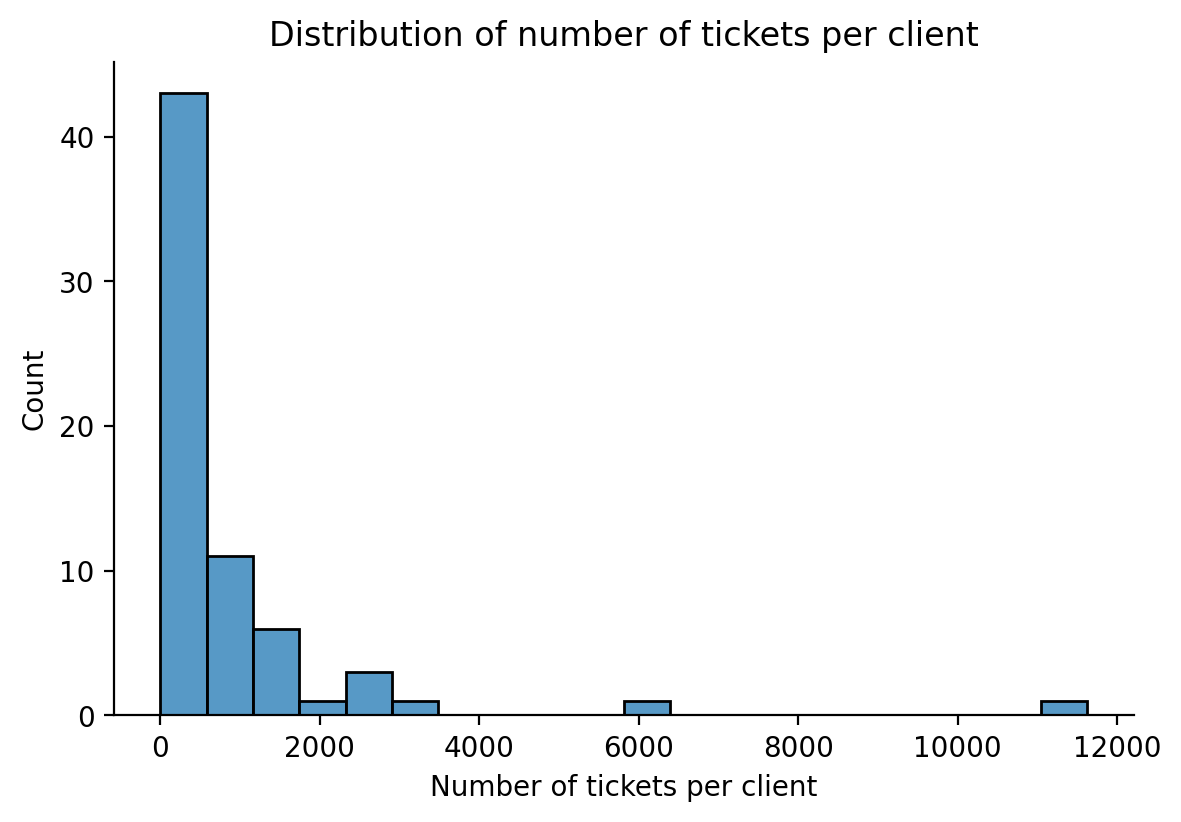

In [22]:
sns.displot(data=client_agg_ticket_cnt, x="#_tickets_per_client", bins=20, aspect=1.5, height=4)
plt.xlabel("Number of tickets per client")
plt.title("Distribution of number of tickets per client")
plt.show()

The number of tickets per client is also skewed so it needs to be considered in a PoC as well.

In [23]:
client_label_agg = df.groupby(["account_id", "contact_reason"])

In [24]:
client_label_agg_cnt = client_label_agg.size() \
                                       .to_frame("num_tickets") \
                                       .reset_index() \
                                       .sort_values(["account_id", "num_tickets"], ascending=[True, False])

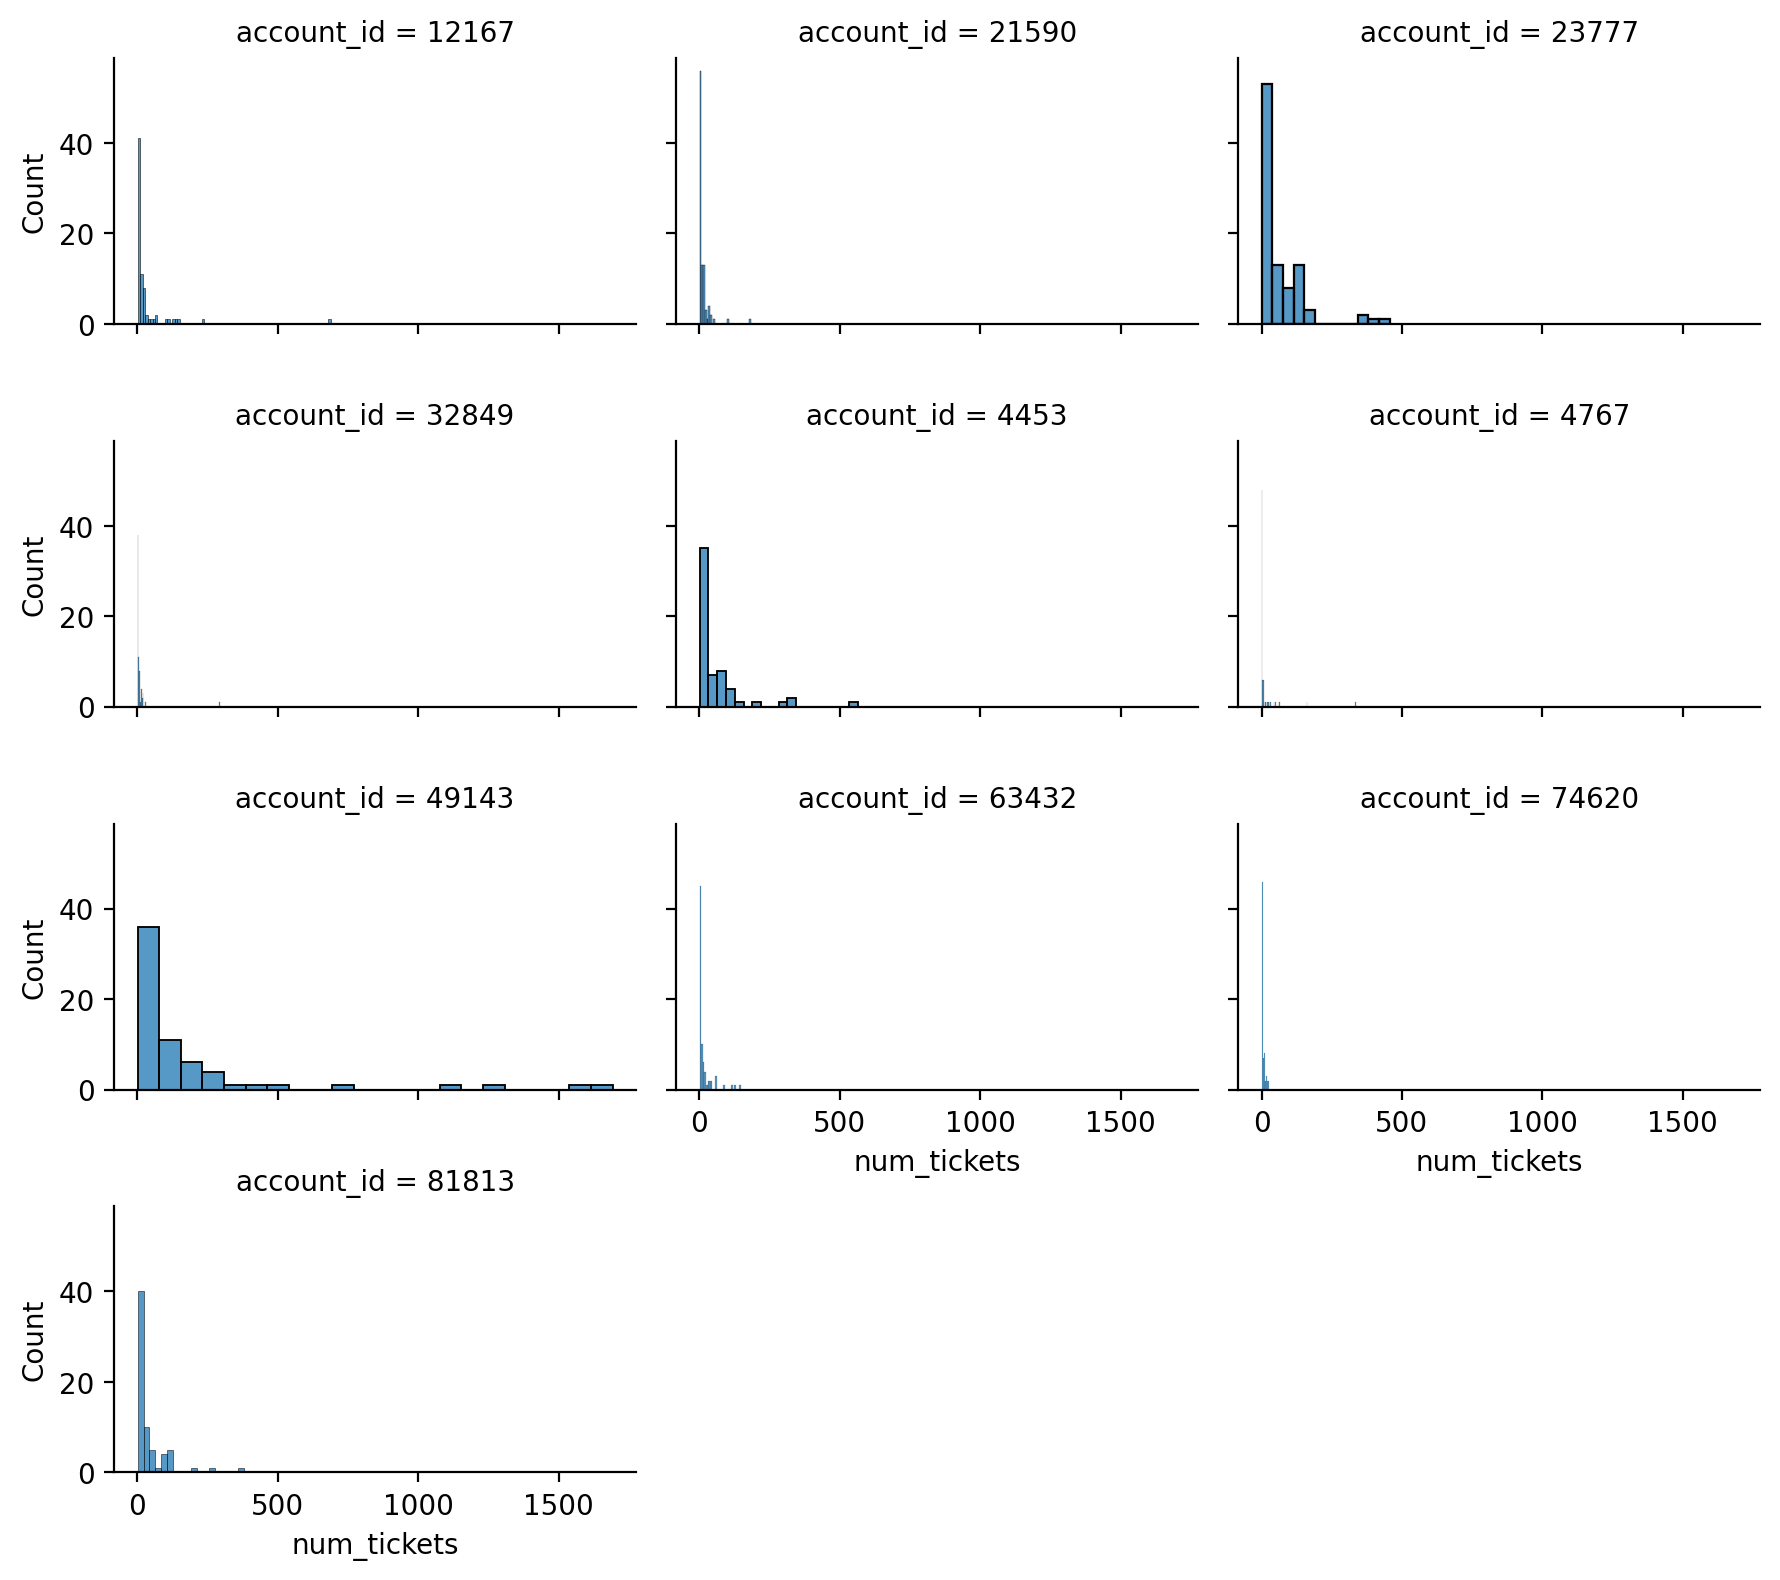

In [25]:
g = sns.FacetGrid(data=client_label_agg_cnt[client_label_agg_cnt.account_id.isin(top_client_ids[::-1])], 
                  col="account_id", col_wrap=3, aspect=1.5, height=2)
g.map(sns.histplot, "num_tickets")
plt.show()

The distribution of the number of tickets per contact reason is skewed for all top10 clients. Due to the nature of ticket requests data, very few of them are quite frequent and the rest of them just happens very rare.

In [26]:
client_label_agg_cnt[client_label_agg_cnt.num_tickets <= 10].account_id.unique().shape[0]

66

Almost 99% of clients have less than or equal to 10 tickets per contact reason and it seems quite interesting to handle them if possible in a PoC.

In [27]:
client_label_agg_cnt.sort_values("num_tickets", ascending=False).head(15)

account_id                 contact_reason  num_tickets
925       49143         "PDF::Poor On Arrival"         1692
944       49143        "WISMO::Not Despatched"         1587
923       49143   "PDF::Failed After Planting"         1289
940       49143             "WISMO::Delivered"         1140
945       49143            "WISMO::On the way"          713
458       32461                        "Other"          692
22        12167                          "N/A"          688
1834      89195                       "Return"          633
1836      89195              "Shipping::WISMO"          614
737        4453                        "Other"          563
917       49143  "No Response Needed (Triage)"          534
195       23353                         "Spam"          522
1830      89195                        "Order"          506
247       23777   "Cancel Request:: No reason"          456
328       23777  "Subscription:: Swap Product"          398

Top 10 popular contact reasons per clients. Amongh those reasons we observe labels such as "Other", "N/A" and "Spam" that are not specific.

In [28]:
client_label_agg_cnt.sort_values("num_tickets", ascending=False).tail(10)

account_id                      contact_reason  num_tickets
1439      70399         "Order::Shipping inquiries"            1
1444      70399                   "Payment::Refund"            1
624       37330     "Shipping::Lost Shipment::USPS"            1
1446      70399       "Payment::Shopify Chargeback"            1
1448      70399                  "Product::Inquiry"            1
1449      70399                  "Product::Testers"            1
1450      70399                "Return::DHL return"            1
1451      70399                "Review::Trustpilot"            1
1454      70399  "Tracking::Delivered not received"            1
1933      92372           "Support::Rewards/Points"            1

Rare examples of contact reasons per client.

In [29]:
label_stats = client_label_agg_cnt.groupby("account_id")["num_tickets"].describe() \
                                  .sort_values("count", ascending=False)

In [30]:
label_stats.sample(10)

count       mean         std  min  25%   50%    75%    max
account_id                                                            
85684         4.0  11.250000   10.719919  1.0  2.5  11.5  20.25   21.0
65133         2.0   1.000000    0.000000  1.0  1.0   1.0   1.00    1.0
57409        17.0   5.294118   10.336614  1.0  1.0   2.0   4.00   44.0
57151         3.0   1.333333    0.577350  1.0  1.0   1.0   1.50    2.0
37274        37.0  11.729730   13.126836  1.0  2.0   9.0  16.00   55.0
74620        72.0   5.416667    6.495394  1.0  1.0   2.0   8.00   27.0
4453         60.0  57.966667  100.222966  1.0  5.0  14.0  68.50  563.0
25489        25.0  20.480000   24.634190  1.0  4.0  11.0  26.00   83.0
79488        34.0  27.970588   52.694365  1.0  4.0  10.0  28.50  289.0
29039         1.0   1.000000         NaN  1.0  1.0   1.0   1.00    1.0

Sample list of target distribution statistics per client.

In [31]:
label_stats[label_stats["75%"] <= 10].shape[0]

33

Almost half of the clients have only a 25% of the number of labels having more than 10 tickets. Those clients have extremely skewed distribution of labels and it also a challenge to address that.

## Email sentence embeddings info

In [32]:
df.email_sentence_embeddings.isnull().sum()

5453

In [33]:
round(5453/df.shape[0] * 100, 1)

9.7

The data shows 5453 (~10%) missing sentence embeddings across the client tickets.

In [34]:
embed_missing_stats = pd.concat([
    df.groupby("account_id").email_sentence_embeddings \
                            .size() \
                            .to_frame("embeddings_cnt_per_client"),
    df.groupby("account_id").email_sentence_embeddings \
                            .apply(lambda x: round(x.isnull().sum() / x.shape[0] * 100, 1)) \
                            .sort_values(ascending=False) \
                            .to_frame("missing_pct_of_embeddings_per_client")
], axis=1).sort_values("missing_pct_of_embeddings_per_client", ascending=False)

In [35]:
embed_missing_stats.head(10)

embeddings_cnt_per_client  missing_pct_of_embeddings_per_client
account_id                                                                 
90756                               1                                 100.0
85684                              45                                 100.0
65210                            1429                                  70.5
88689                               2                                  50.0
68999                             635                                  45.4
57130                             490                                  41.2
45491                              79                                  40.5
62530                               7                                  28.6
11539                             214                                  26.6
57151                               4                                  25.0

Clients such as **90756** and **85684** do not have any email sentence embeddings at all.

What are the **common contact reasons** having missing sentence embeddings?

In [36]:
client_ids = embed_missing_stats[embed_missing_stats.missing_pct_of_embeddings_per_client >= 50.].index.tolist()
top_missing_labels =  df[df.account_id.isin(client_ids)].contact_reason.value_counts().to_frame("cnt")

In [37]:
top_missing_labels.head(10)

cnt
contact_reason                         
"Misc::Spam"                        304
"Returns::Return Label"             112
"Existing Order::WISMO"             109
"Existing Order::Change/Cancel"     100
"Store Message::QAS"                 83
"Subscription::Cancel"               60
"Existing Order::Price Adjust"       57
"Store Message::Customer Question"   49
"Store Message::Training"            48
"Pre-Sale::Discount"                 47

In [38]:
df["ticket_datetime"] = pd.to_datetime(df.unix_timestamp.apply(lambda x: datetime.fromtimestamp(x)))

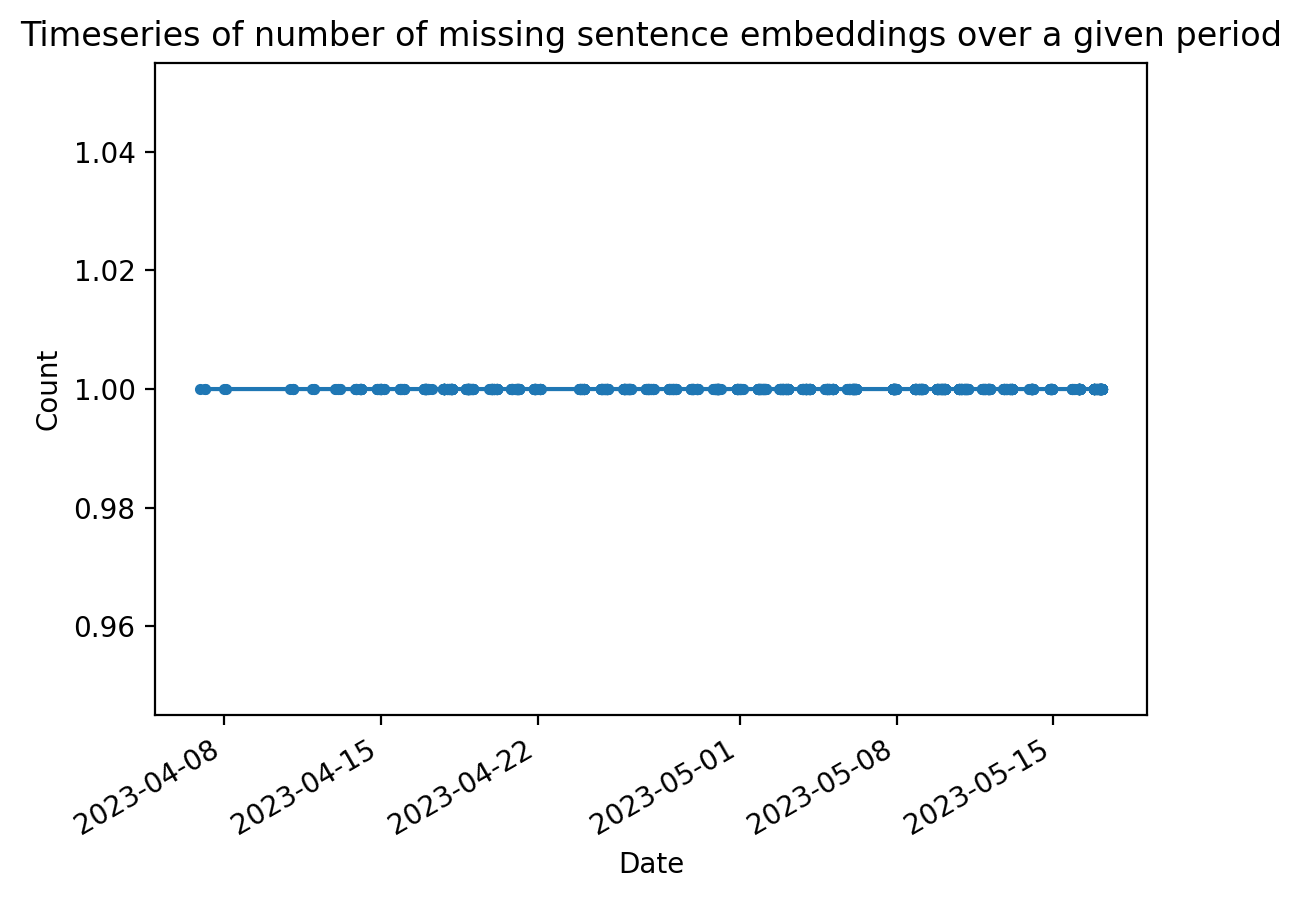

In [39]:
df[df.account_id.isin(client_ids)].ticket_datetime.value_counts().plot(marker=".")
plt.title("Timeseries of number of missing sentence embeddings over a given period")
plt.ylabel("Count")
plt.xlabel("Date")
plt.show()

The missing embeddings distributed quite uniformly over a given period.

The list of contact reasons with missing sentence embeddings might signal about the following issues:
- Ticket is represented as an empty email
- Technical failure in the ticket support system
- Tickets are affected by development or integration processes in the system.

We might ignore them while training a model or build a model to impute the missing embeddings for the tickets. One of the candidate model is vanilla k nearest neighbours (kNN).

In [45]:
df["email_sentence_embeddings"] = df.email_sentence_embeddings.apply(lambda x: json.loads(x) if x else None)
df["email_sentence_len"] = df.email_sentence_embeddings.apply(lambda x: len(x) if x else None)

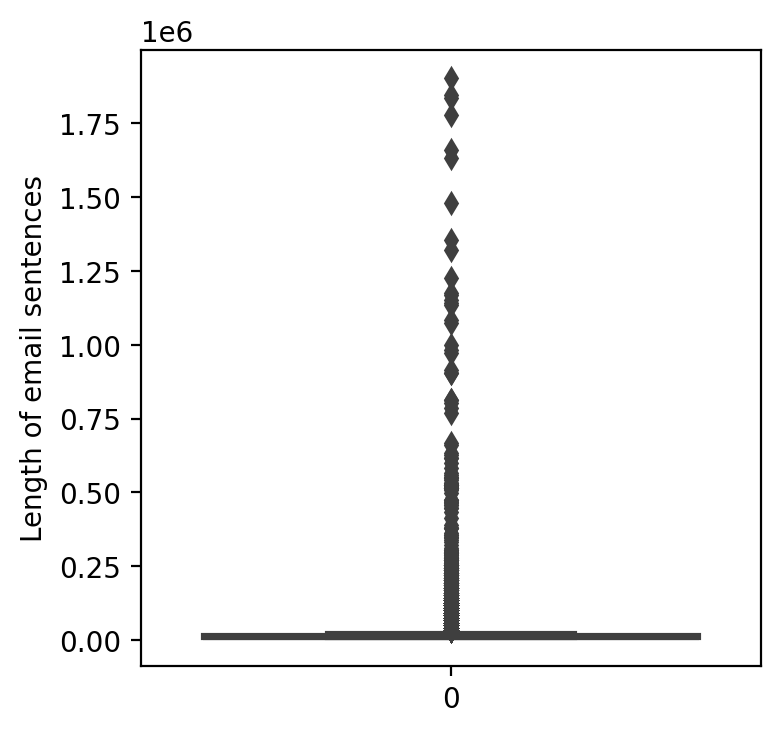

In [41]:
plt.figure(figsize=(4,4))
sns.boxplot(df.email_sentence_len)
plt.ylabel("Length of email sentences")
plt.show()

In [42]:
df.email_sentence_len.describe().to_frame()

email_sentence_len
count        5.071900e+04
mean         1.950534e+04
std          4.027138e+04
min          8.398000e+03
25%          8.453000e+03
50%          8.471000e+03
75%          1.693000e+04
max          1.904763e+06

75% of tickets have at most 2 sentences and half population of tickets have only single embedding.

There are a couple of ideas to wrap up the multiple embeddings of the tickets onto a single one to preserve the embedding dimension (in this case is 384):
- averaging or mean pooling the features of every dimension to get the essence of all the sentences in the ticket.
- max pooling the features of every dimension to focus on most important features of all the sentences in the ticket.

In [62]:
def tsne_reduction_and_plot_embeddings(embeddings, labels, title):
    """
    TSNE reduction and plot embeddings.
    :param embeddings: pretrained feature vectors
    :param labels: target variable
    :return:
    """
    # Learn embeddings.
    print("Learning embeddings...")
    np.random.seed(42)
    model = TSNE(n_components=2, random_state=42)
    embedded = model.fit_transform(embeddings)

    # Plot embeddings.
    print("Plotting embeddings...")

    embedded_df = pd.DataFrame(embedded)
    embedded_df = embedded_df.rename(columns={0:'x',1:'y'})
    embedded_df["account_id"] = labels

    fig = px.scatter(
        embedded_df, x='x', y='y',
        color='account_id', template='simple_white',
        height=600, title=title)
    fig.show()

In [72]:
mean_pooled_embeddings = df.set_index("account_id").email_sentence_embeddings \
                           .apply(lambda x: np.mean([emb for _, emb in x.items()], axis=0) if x else None) \
                           .dropna()
max_pooled_embeddings = df.set_index("account_id").email_sentence_embeddings \
                            .apply(lambda x: np.max([emb for _, emb in x.items()], axis=0) if x else None) \
                            .dropna()

In [73]:
labels, embeddings = mean_pooled_embeddings.index.values, np.array([vec.tolist() for vec in mean_pooled_embeddings.values])
tsne_reduction_and_plot_embeddings(embeddings, labels, "Email Sentence Mean pooled Embedding Visualization per client")

Learning embeddings...
Plotting embeddings...


In [74]:
labels, embeddings = max_pooled_embeddings.index.values, np.array([vec.tolist() for vec in max_pooled_embeddings.values])
tsne_reduction_and_plot_embeddings(embeddings, labels, "Email Sentence Max pooled Embedding Visualization per client")

Learning embeddings...


The idea is to visualize the sentence embeddings and observe the preserved associated structure of email sentences per client derived from TSNE reduction.